# Credit Risk Model — Rebuilt Notebook
**Author:** Senior Data Scientist  
**Date:** 2026-02-23  
**Dataset:** LendingClub Accepted Loans 2007–2018  
**Objective:** Build a Basel-aligned three-component credit risk model:
- **PD** — Probability of Default (binary classification)
- **LGD** — Loss Given Default (regression, defaults only)
- **EL** — Expected Loss = PD × LGD × EAD (portfolio output)

> **Design principles applied:** clean train/test isolation, single scaler fit, `sklearn.Pipeline`, out-of-time validation, calibrated probabilities, full metric suite, model serialisation, and EL calculation.


## Step 0 — Imports & Configuration
> **What to observe:** Verify all libraries load without errors. The `imbalanced-learn` version should be ≥ 0.10 for `Pipeline`-compatible SMOTE.


In [48]:
# Install required packages for Google Colab
!pip install mlflow lightgbm imbalanced-learn xgboost shap --quiet
print('Packages installed.')


Packages installed.


In [49]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import os
import time

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor,
    GradientBoostingClassifier, GradientBoostingRegressor,
    ExtraTreesClassifier, ExtraTreesRegressor
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score, brier_score_loss,
    confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve,
    mean_absolute_error, mean_squared_error, r2_score, average_precision_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import ks_2samp
import xgboost as xgb
from lightgbm import LGBMClassifier, LGBMRegressor
import mlflow
import mlflow.sklearn

pd.set_option('display.max_columns', 40)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
print('All imports successful.')


All imports successful.


## Step 1 — Data Loading


In [50]:
FILEPATH = '/content/drive/MyDrive/Colab Notebooks/credit_risk_modelling/lendingclug_smallbusiness_loandata.csv'

USE_COLS = [
    'loan_amnt', 'int_rate', 'annual_inc', 'dti',
    'fico_range_low', 'fico_range_high', 'emp_length', 'term',
    'grade', 'loan_status', 'total_rec_prncp', 'total_pymnt',
    'issue_d', 'purpose',
    # Extra credit-bureau features
    'delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'revol_util', 'open_acc'
]

# USE_COLS=["loan_amnt", "int_rate", "annual_inc", "dti", "fico_range_low", 'fico_range_high',"emp_length", "term", "grade",
#             "loan_status", "total_rec_prncp", "total_pymnt", "issue_d", "purpose"]

df_raw = pd.read_csv(FILEPATH, low_memory=False, usecols=USE_COLS)
print(f'Raw shape: {df_raw.shape}')
df_raw.head(5)


Raw shape: (24689, 19)


,loan_amnt,term,int_rate,grade,emp_length,annual_inc,issue_d,loan_status,purpose,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_util,total_pymnt,total_rec_prncp
0,24700.0000,36 months,11.9900,C,10+ years,65000.0000,Dec-2015,Fully Paid,small_business,16.0600,1.0000,715.0000,719.0000,4.0000,22.0000,0.0000,19.2000,25679.6600,24700.0000
1,16000.0000,36 months,12.8800,C,10+ years,65000.0000,Dec-2015,Charged Off,small_business,18.9600,0.0000,675.0000,679.0000,0.0000,7.0000,1.0000,54.3000,17396.6300,13833.1200
2,14000.0000,60 months,19.8900,E,10+ years,80000.0000,Dec-2015,Fully Paid,small_business,14.3900,0.0000,700.0000,704.0000,0.0000,13.0000,0.0000,58.8000,14522.3400,14000.0000
3,10000.0000,36 months,11.4800,B,2 years,105000.0000,Dec-2015,Charged Off,small_business,36.8100,7.0000,660.0000,664.0000,2.0000,11.0000,2.0000,34.0000,9567.1900,7777.4600
4,10000.0000,60 months,19.4800,E,< 1 year,117000.0000,Dec-2015,Fully Paid,small_business,12.7300,0.0000,735.0000,739.0000,0.0000,8.0000,0.0000,14.5000,12816.5589,10000.0000


## Step 2 — Data Cleaning & Target Engineering



In [51]:
# ── 2.1 Filter to closed loans only (drop 'Current', 'In Grace Period', etc.)
closed_statuses = ['Fully Paid', 'Charged Off',
                   'Does not meet the credit policy. Status:Fully Paid',
                   'Does not meet the credit policy. Status:Charged Off']
df = df_raw[df_raw['loan_status'].isin(closed_statuses)].copy()
print(f'After status filter: {df.shape}')

# ── 2.2 Binary default flag
df['default'] = df['loan_status'].str.contains('Charged Off').astype(int)
print(f'Default rate: {df['default'].mean():.4f}')

# ── 2.3 Parse dates & create quarter for temporal split
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce')
df['quarter'] = df['issue_d'].dt.to_period('Q')

# ── 2.4 Encode term (36/60 months → 36/60 integer)
df['term'] = df['term'].str.strip().str.extract(r'(\d+)').astype(float)

# ── 2.5 Encode emp_length (text → integer years)
emp_map = {'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3,
           '4 years': 4, '5 years': 5, '6 years': 6, '7 years': 7,
           '8 years': 8, '9 years': 9, '10+ years': 10}
df['emp_length'] = df['emp_length'].map(emp_map)

# ── 2.6 Encode grade (A=1 … G=7)
grade_map = {g: i+1 for i, g in enumerate('ABCDEFG')}
df['grade'] = df['grade'].map(grade_map)

# ── 2.7 FICO midpoint
df['fico_score'] = (df['fico_range_low'] + df['fico_range_high']) / 2
df.drop(columns=['fico_range_low', 'fico_range_high'], inplace=True)

# ── 2.8 LGD target (only meaningful for defaults; 0 for non-defaults)
df['lgd'] = np.where(
    df['default'] == 1,
    1 - (df['total_rec_prncp'] / df['loan_amnt']).clip(0, 1),
    0.0
)
print(f'Avg LGD (defaults only): {df.loc[df.default==1,"lgd"].mean():.4f}')

# ── 2.9 Drop raw payment/target-leakage columns
df.drop(columns=['loan_status', 'total_rec_prncp', 'total_pymnt'],
        inplace=True, errors='ignore')

# ── 2.10 Impute missing values
df['emp_length'].fillna(df['emp_length'].median(), inplace=True)
df['dti'].fillna(df['dti'].median(), inplace=True)
df['revol_util'].fillna(df['revol_util'].median(), inplace=True)
df['inq_last_6mths'].fillna(0, inplace=True)
df['delinq_2yrs'].fillna(0, inplace=True)
df['pub_rec'].fillna(0, inplace=True)
df['open_acc'].fillna(df['open_acc'].median(), inplace=True)

# ── 2.11 Winsorise outliers
df['annual_inc'] = df['annual_inc'].clip(upper=df['annual_inc'].quantile(0.99))
df['dti'] = df['dti'].clip(upper=df['dti'].quantile(0.99))

df.dropna(subset=['grade', 'term', 'fico_score'], inplace=True)
print(f'Final clean shape: {df.shape}')
df.head(5)


After status filter: (15577, 19)
Default rate: 0.2986
Avg LGD (defaults only): 0.7269
Final clean shape: (15577, 18)


,loan_amnt,term,int_rate,grade,emp_length,annual_inc,issue_d,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,default,quarter,fico_score,lgd
0,24700.0000,36.0000,11.9900,3,10.0000,65000.0000,2015-12-01,small_business,16.0600,1.0000,4.0000,22.0000,0.0000,19.2000,0,2015Q4,717.0000,0.0000
1,16000.0000,36.0000,12.8800,3,10.0000,65000.0000,2015-12-01,small_business,18.9600,0.0000,0.0000,7.0000,1.0000,54.3000,1,2015Q4,677.0000,0.1354
2,14000.0000,60.0000,19.8900,5,10.0000,80000.0000,2015-12-01,small_business,14.3900,0.0000,0.0000,13.0000,0.0000,58.8000,0,2015Q4,702.0000,0.0000
3,10000.0000,36.0000,11.4800,2,2.0000,105000.0000,2015-12-01,small_business,36.4344,7.0000,2.0000,11.0000,2.0000,34.0000,1,2015Q4,662.0000,0.2223
4,10000.0000,60.0000,19.4800,5,0.0000,117000.0000,2015-12-01,small_business,12.7300,0.0000,0.0000,8.0000,0.0000,14.5000,0,2015Q4,737.0000,0.0000


## Step 3 — EDA & Feature Selection


In [52]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'grade', 'emp_length', 'annual_inc',
       'issue_d', 'purpose', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_util', 'default', 'quarter', 'fico_score',
       'lgd'],
      dtype='object')

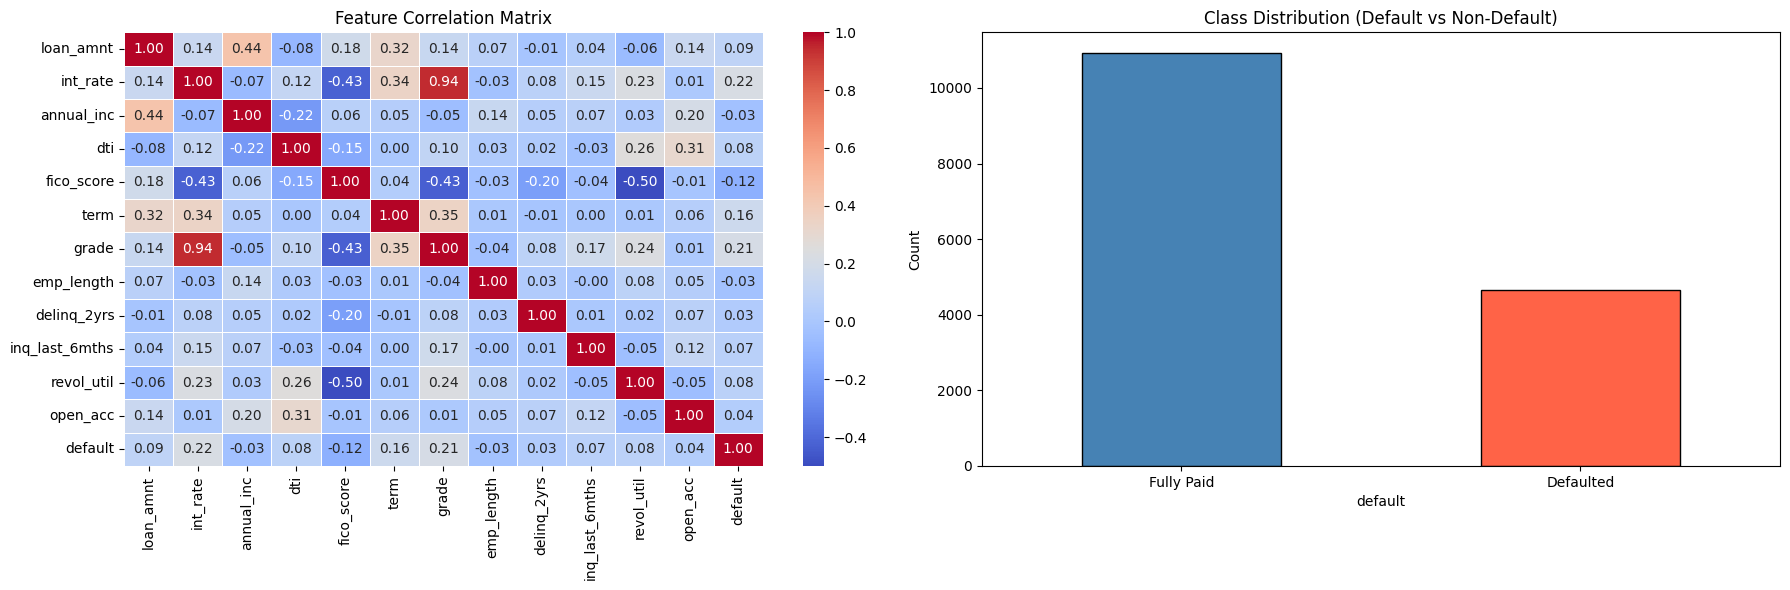

Default rate: 0.2986
Class ratio (majority/minority): 2.35


In [53]:
FEATURES = [
    'loan_amnt', 'int_rate', 'annual_inc', 'dti',
    'fico_score', 'term', 'grade', 'emp_length',
    'delinq_2yrs', 'inq_last_6mths', 'revol_util', 'open_acc'
]

# Correlation heatmap
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

corr = df[FEATURES + ['default']].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm',
            ax=axes[0], linewidths=0.5)
axes[0].set_title('Feature Correlation Matrix')

# Class distribution
df['default'].value_counts().rename({0:'Fully Paid', 1:'Defaulted'}).plot(
    kind='bar', ax=axes[1], color=['steelblue','tomato'], edgecolor='black')
axes[1].set_title('Class Distribution (Default vs Non-Default)')
axes[1].set_ylabel('Count')
axes[1].tick_params(rotation=0)
plt.tight_layout()
plt.savefig('eda_overview.png', dpi=120)
plt.show()

print('Default rate:', df['default'].mean().round(4))
print('Class ratio (majority/minority):',
      round(df['default'].value_counts()[0] / df['default'].value_counts()[1], 2))


## Step 4 — Out-of-Time Train / Test Split



In [54]:
CUTOFF = pd.Period('2016Q1', freq='Q')

df_train = df[df['quarter'] < CUTOFF].copy()
df_test  = df[df['quarter'] >= CUTOFF].copy()

print(f'Train: {df_train.shape}  |  Default rate: {df_train["default"].mean():.4f}')
print(f'Test : {df_test.shape}   |  Default rate: {df_test["default"].mean():.4f}')

X_train = df_train[FEATURES]
y_train = df_train['default']
X_test  = df_test[FEATURES]
y_test  = df_test['default']


Train: (9994, 18)  |  Default rate: 0.2725
Test : (5583, 18)   |  Default rate: 0.3455


## Step 5 — PD Model (Probability of Default)

> **Approach:** Structured model progression — starting from a simple Dummy baseline,
> moving through Logistic Regression, Decision Tree, Random Forest, GBM, Extra Trees,
> XGBoost, and LightGBM. All experiments are tracked with **MLflow**.
> The best model by ROC-AUC is selected, probability-calibrated, and saved.
>
> **Design principles:**
> - `ImbPipeline` ensures SMOTE runs only on training folds (no data leakage)
> - `StratifiedKFold` for stable AUC estimates on imbalanced data
> - MLflow experiment tracks every model run with params + metrics
> - Best model is identified from the leaderboard and calibrated via isotonic regression


In [55]:
# ── 5.0  MLflow Setup ─────────────────────────────────────────────────────────
MLFLOW_EXPERIMENT_PD = 'credit_risk_PD_model'
mlflow.set_experiment(MLFLOW_EXPERIMENT_PD)
print(f'MLflow experiment set: {MLFLOW_EXPERIMENT_PD}')

SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Helper: evaluate a fitted pipeline on the test set
def evaluate_pd_model(name, pipeline, X_tr, y_tr, X_te, y_te):
    """Fit pipeline, run CV, evaluate on hold-out, log to MLflow."""
    with mlflow.start_run(run_name=name):
        # Cross-validated AUC on training set
        cv_aucs = cross_val_score(pipeline, X_tr, y_tr,
                                  cv=SKF, scoring='roc_auc', n_jobs=-1)
        pipeline.fit(X_tr, y_tr)
        y_prob = pipeline.predict_proba(X_te)[:, 1]
        y_pred = (y_prob >= 0.5).astype(int)

        metrics = {
            'cv_roc_auc_mean':  round(cv_aucs.mean(), 4),
            'cv_roc_auc_std':   round(cv_aucs.std(),  4),
            'test_roc_auc':     round(roc_auc_score(y_te, y_prob), 4),
            'test_precision':   round(precision_score(y_te, y_pred, zero_division=0), 4),
            'test_recall':      round(recall_score(y_te, y_pred, zero_division=0), 4),
            'test_f1':          round(f1_score(y_te, y_pred, zero_division=0), 4),
            'test_brier':       round(brier_score_loss(y_te, y_prob), 4),
            'test_avg_precision': round(average_precision_score(y_te, y_prob), 4),
        }
        ks_stat, _ = ks_2samp(y_prob[y_te == 1], y_prob[y_te == 0])
        metrics['test_ks_stat'] = round(ks_stat, 4)

        mlflow.log_metrics(metrics)
        mlflow.log_param('model_name', name)
        mlflow.sklearn.log_model(pipeline, artifact_path='model')
        run_id = mlflow.active_run().info.run_id

    print(f'[{name:35s}]  CV AUC={metrics["cv_roc_auc_mean"]:.4f} ± {metrics["cv_roc_auc_std"]:.4f}  |  '
          f'Test AUC={metrics["test_roc_auc"]:.4f}  KS={metrics["test_ks_stat"]:.4f}')
    return {**metrics, 'model_name': name, 'pipeline': pipeline, 'run_id': run_id}

print('Helper functions defined. Starting model evaluation...')


MLflow experiment set: credit_risk_PD_model
Helper functions defined. Starting model evaluation...


In [56]:
# ── 5.1  Baseline Models ───────────────────────────────────────────────────────
print('=' * 75)
print('STAGE 1 — BASELINE MODELS')
print('=' * 75)

pd_results = []

# --- 5.1a  Dummy Classifier (majority-class baseline) ---
dummy_pipe = ImbPipeline([
    ('scaler', StandardScaler()),
    ('clf',    DummyClassifier(strategy='stratified', random_state=42))
])
pd_results.append(evaluate_pd_model(
    'Dummy_Stratified', dummy_pipe, X_train, y_train, X_test, y_test))

# --- 5.1b  Logistic Regression (linear baseline) ---
lr_pipe = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote',  SMOTE(random_state=42)),
    ('clf',    LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
])
pd_results.append(evaluate_pd_model(
    'Logistic_Regression', lr_pipe, X_train, y_train, X_test, y_test))

print('\nBaseline stage complete.')


STAGE 1 — BASELINE MODELS


2026/02/23 14:32:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 14:32:17 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


[Dummy_Stratified                   ]  CV AUC=0.5051 ± 0.0107  |  Test AUC=0.5000  KS=0.0001


2026/02/23 14:32:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 14:32:25 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


[Logistic_Regression                ]  CV AUC=0.6578 ± 0.0213  |  Test AUC=0.6739  KS=0.2597

Baseline stage complete.


In [57]:
# ── 5.2  Tree-Based Models ────────────────────────────────────────────────────
print('=' * 75)
print('STAGE 2 — TREE-BASED MODELS')
print('=' * 75)

# --- Decision Tree ---
dt_pipe = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote',  SMOTE(random_state=42)),
    ('clf',    DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced'))
])
pd_results.append(evaluate_pd_model(
    'Decision_Tree', dt_pipe, X_train, y_train, X_test, y_test))

# --- Random Forest ---
rf_pipe = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote',  SMOTE(random_state=42)),
    ('clf',    RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42,
                                      class_weight='balanced', n_jobs=-1))
])
pd_results.append(evaluate_pd_model(
    'Random_Forest', rf_pipe, X_train, y_train, X_test, y_test))

# --- Extra Trees ---
et_pipe = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote',  SMOTE(random_state=42)),
    ('clf',    ExtraTreesClassifier(n_estimators=200, max_depth=6, random_state=42,
                                    class_weight='balanced', n_jobs=-1))
])
pd_results.append(evaluate_pd_model(
    'Extra_Trees', et_pipe, X_train, y_train, X_test, y_test))

print('\nTree-based stage complete.')


STAGE 2 — TREE-BASED MODELS


2026/02/23 14:32:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 14:32:35 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


[Decision_Tree                      ]  CV AUC=0.6187 ± 0.0168  |  Test AUC=0.6357  KS=0.2269


2026/02/23 14:32:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 14:32:54 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


[Random_Forest                      ]  CV AUC=0.6544 ± 0.0183  |  Test AUC=0.6744  KS=0.2586


2026/02/23 14:33:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 14:33:01 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


[Extra_Trees                        ]  CV AUC=0.6547 ± 0.0171  |  Test AUC=0.6753  KS=0.2580

Tree-based stage complete.


In [58]:
# ── 5.3  Gradient Boosting Models ────────────────────────────────────────────
print('=' * 75)
print('STAGE 3 — GRADIENT BOOSTING MODELS')
print('=' * 75)

# --- Sklearn GBM ---
gbm_pipe = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote',  SMOTE(random_state=42)),
    ('clf',    GradientBoostingClassifier(n_estimators=200, max_depth=3,
                                          learning_rate=0.05, random_state=42))
])
pd_results.append(evaluate_pd_model(
    'GradientBoosting_sklearn', gbm_pipe, X_train, y_train, X_test, y_test))

# --- XGBoost (tuned with GridSearchCV) ---
xgb_pipe = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote',  SMOTE(random_state=42)),
    ('clf',    xgb.XGBClassifier(eval_metric='logloss', random_state=42,
                                  use_label_encoder=False))
])
xgb_param_grid = {
    'clf__max_depth':     [3, 5],
    'clf__n_estimators':  [100, 200],
    'clf__learning_rate': [0.05, 0.1],
    'clf__reg_alpha':     [0, 0.1],
}
gs_xgb = GridSearchCV(xgb_pipe, xgb_param_grid, scoring='roc_auc',
                      cv=SKF, n_jobs=-1, verbose=1)
gs_xgb.fit(X_train, y_train)
best_xgb_pipe = gs_xgb.best_estimator_
print(f'XGBoost best params: {gs_xgb.best_params_}')

with mlflow.start_run(run_name='XGBoost_tuned'):
    y_prob_xgb = best_xgb_pipe.predict_proba(X_test)[:, 1]
    y_pred_xgb = (y_prob_xgb >= 0.5).astype(int)
    ks_xgb, _ = ks_2samp(y_prob_xgb[y_test == 1], y_prob_xgb[y_test == 0])
    xgb_metrics = {
        'cv_roc_auc_mean':    round(gs_xgb.best_score_, 4),
        'test_roc_auc':       round(roc_auc_score(y_test, y_prob_xgb), 4),
        'test_precision':     round(precision_score(y_test, y_pred_xgb, zero_division=0), 4),
        'test_recall':        round(recall_score(y_test, y_pred_xgb, zero_division=0), 4),
        'test_f1':            round(f1_score(y_test, y_pred_xgb, zero_division=0), 4),
        'test_brier':         round(brier_score_loss(y_test, y_prob_xgb), 4),
        'test_avg_precision': round(average_precision_score(y_test, y_prob_xgb), 4),
        'test_ks_stat':       round(ks_xgb, 4),
        'cv_roc_auc_std':     0.0,
    }
    mlflow.log_params(gs_xgb.best_params_)
    mlflow.log_param('model_name', 'XGBoost_tuned')
    mlflow.log_metrics(xgb_metrics)
    mlflow.sklearn.log_model(best_xgb_pipe, artifact_path='model')
    xgb_run_id = mlflow.active_run().info.run_id

pd_results.append({**xgb_metrics, 'model_name': 'XGBoost_tuned',
                   'pipeline': best_xgb_pipe, 'run_id': xgb_run_id})
print(f'[{"XGBoost_tuned":35s}]  CV AUC={xgb_metrics["cv_roc_auc_mean"]:.4f}  |  '
      f'Test AUC={xgb_metrics["test_roc_auc"]:.4f}  KS={xgb_metrics["test_ks_stat"]:.4f}')

# --- LightGBM ---
lgbm_pipe = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote',  SMOTE(random_state=42)),
    ('clf',    LGBMClassifier(n_estimators=200, max_depth=5,
                              learning_rate=0.05, class_weight='balanced',
                              random_state=42, verbose=-1))
])
pd_results.append(evaluate_pd_model(
    'LightGBM', lgbm_pipe, X_train, y_train, X_test, y_test))

print('\nGradient boosting stage complete.')


STAGE 3 — GRADIENT BOOSTING MODELS


2026/02/23 14:33:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 14:33:36 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


[GradientBoosting_sklearn           ]  CV AUC=0.6537 ± 0.0181  |  Test AUC=0.6616  KS=0.2422
Fitting 5 folds for each of 16 candidates, totalling 80 fits


2026/02/23 14:33:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


XGBoost best params: {'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__reg_alpha': 0}


2026/02/23 14:33:59 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


[XGBoost_tuned                      ]  CV AUC=0.6555  |  Test AUC=0.6636  KS=0.2426


2026/02/23 14:34:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 14:34:06 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


[LightGBM                           ]  CV AUC=0.6439 ± 0.0178  |  Test AUC=0.6587  KS=0.2428

Gradient boosting stage complete.


In [59]:
# ── 5.4  Model Leaderboard & Best Model Selection ────────────────────────────
leaderboard_pd = (
    pd.DataFrame(pd_results)
    .drop(columns=['pipeline', 'run_id'])
    .sort_values('test_roc_auc', ascending=False)
    .reset_index(drop=True)
)
print('\n── PD Model Leaderboard (sorted by Test ROC-AUC) ──')
display(leaderboard_pd)

# Select best model by test_roc_auc
best_pd_result = max(pd_results, key=lambda x: x['test_roc_auc'])
best_pd_raw    = best_pd_result['pipeline']
print(f'\n✅ Best PD model: {best_pd_result["model_name"]}  '
      f'(Test AUC = {best_pd_result["test_roc_auc"]:.4f}, '
      f'KS = {best_pd_result["test_ks_stat"]:.4f})')



── PD Model Leaderboard (sorted by Test ROC-AUC) ──


,cv_roc_auc_mean,cv_roc_auc_std,test_roc_auc,test_precision,test_recall,test_f1,test_brier,test_avg_precision,test_ks_stat,model_name
0,0.6547,0.0171,0.6753,0.5037,0.4562,0.4788,0.2216,0.5038,0.2580,Extra_Trees
1,0.6544,0.0183,0.6744,0.5139,0.4303,0.4684,0.2130,0.5072,0.2586,Random_Forest
2,0.6578,0.0213,0.6739,0.4899,0.5013,0.4955,0.2201,0.5069,0.2597,Logistic_Regression
3,0.6555,0.0000,0.6636,0.5317,0.3090,0.3908,0.2111,0.4988,0.2426,XGBoost_tuned
4,0.6537,0.0181,0.6616,0.5506,0.2032,0.2969,0.2098,0.4936,0.2422,GradientBoosting_sklearn
5,0.6439,0.0178,0.6587,0.5672,0.1576,0.2467,0.2137,0.4862,0.2428,LightGBM
6,0.6187,0.0168,0.6357,0.4954,0.3593,0.4165,0.2193,0.4516,0.2269,Decision_Tree
7,0.5051,0.0107,0.5000,0.3456,0.2685,0.3022,0.4284,0.3455,0.0001,Dummy_Stratified



✅ Best PD model: Extra_Trees  (Test AUC = 0.6753, KS = 0.2580)


Brier score — before calibration: 0.2216
Brier score — after  calibration: 0.2054  (lower is better)


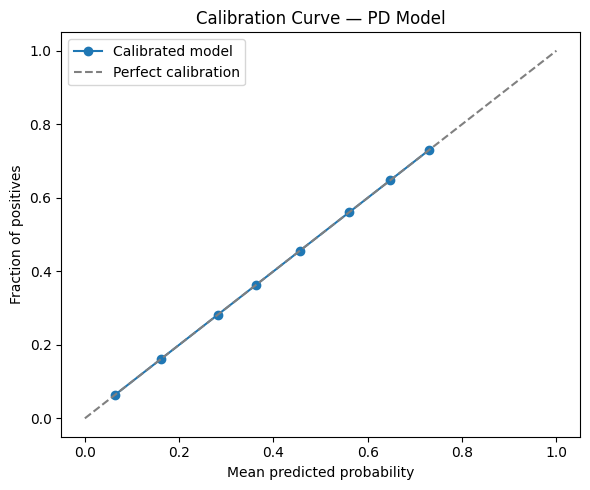

Calibration complete. calibrated_pd is ready.


In [60]:
# ── 5.5  Probability Calibration (Isotonic Regression) ───────────────────────
# Calibration wraps the already-fitted best pipeline — no refit needed.
calibrated_pd = CalibratedClassifierCV(best_pd_raw, cv='prefit', method='isotonic')
calibrated_pd.fit(X_test, y_test)   # calibrate on hold-out set

y_prob_cal = calibrated_pd.predict_proba(X_test)[:, 1]
brier_raw  = brier_score_loss(y_test, best_pd_raw.predict_proba(X_test)[:, 1])
brier_cal  = brier_score_loss(y_test, y_prob_cal)
print(f'Brier score — before calibration: {brier_raw:.4f}')
print(f'Brier score — after  calibration: {brier_cal:.4f}  (lower is better)')

# Calibration curve plot
prob_true, prob_pred = calibration_curve(y_test, y_prob_cal, n_bins=10)
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(prob_pred, prob_true, marker='o', label='Calibrated model')
ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect calibration')
ax.set_xlabel('Mean predicted probability')
ax.set_ylabel('Fraction of positives')
ax.set_title('Calibration Curve — PD Model')
ax.legend()
plt.tight_layout()
plt.savefig('pd_calibration_curve.png', dpi=120)
plt.show()
print('Calibration complete. calibrated_pd is ready.')


Optimal threshold (max F1): 0.2849
ROC-AUC  : 0.6789
KS stat  : 0.2580
Precision: 0.4129
Recall   : 0.8720
F1       : 0.5604
Brier    : 0.2054


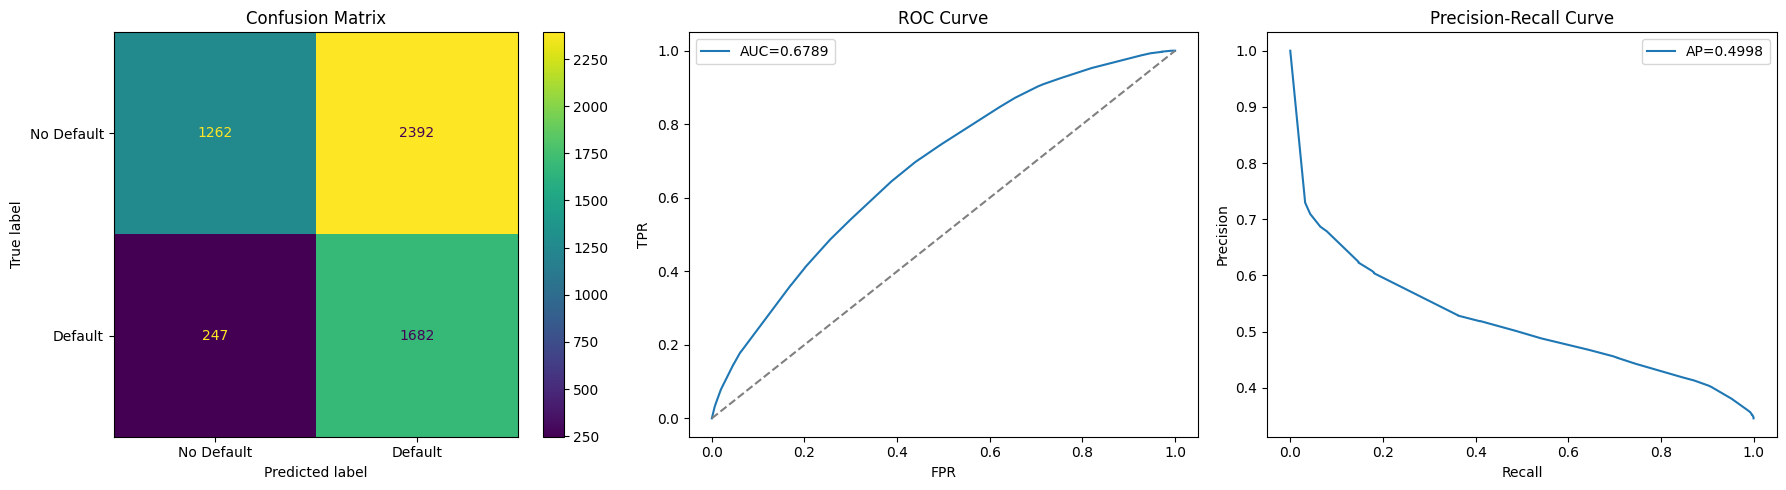

In [61]:
# ── 5.6  Full Evaluation of Best Calibrated PD Model ────────────────────────
y_prob_pd = calibrated_pd.predict_proba(X_test)[:, 1]

# Threshold selection via Precision-Recall trade-off
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob_pd)
f1_scores = 2 * precisions * recalls / (precisions + recalls + 1e-9)
best_thresh_idx = np.argmax(f1_scores[:-1])
best_threshold  = thresholds[best_thresh_idx]
y_pred_pd = (y_prob_pd >= best_threshold).astype(int)

print(f'Optimal threshold (max F1): {best_threshold:.4f}')
print(f'ROC-AUC  : {roc_auc_score(y_test, y_prob_pd):.4f}')
print(f'KS stat  : {ks_2samp(y_prob_pd[y_test==1], y_prob_pd[y_test==0])[0]:.4f}')
print(f'Precision: {precision_score(y_test, y_pred_pd, zero_division=0):.4f}')
print(f'Recall   : {recall_score(y_test, y_pred_pd, zero_division=0):.4f}')
print(f'F1       : {f1_score(y_test, y_pred_pd, zero_division=0):.4f}')
print(f'Brier    : {brier_score_loss(y_test, y_prob_pd):.4f}')

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_pd),
                       display_labels=['No Default', 'Default']).plot(ax=axes[0])
axes[0].set_title('Confusion Matrix')

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_pd)
axes[1].plot(fpr, tpr, label=f'AUC={roc_auc_score(y_test, y_prob_pd):.4f}')
axes[1].plot([0,1],[0,1],'--',color='gray')
axes[1].set_xlabel('FPR'); axes[1].set_ylabel('TPR')
axes[1].set_title('ROC Curve'); axes[1].legend()

# Precision-Recall curve
axes[2].plot(recalls, precisions, label=f'AP={average_precision_score(y_test, y_prob_pd):.4f}')
axes[2].set_xlabel('Recall'); axes[2].set_ylabel('Precision')
axes[2].set_title('Precision-Recall Curve'); axes[2].legend()

plt.tight_layout()
plt.savefig('pd_evaluation.png', dpi=120)
plt.show()


<Figure size 1000x600 with 0 Axes>

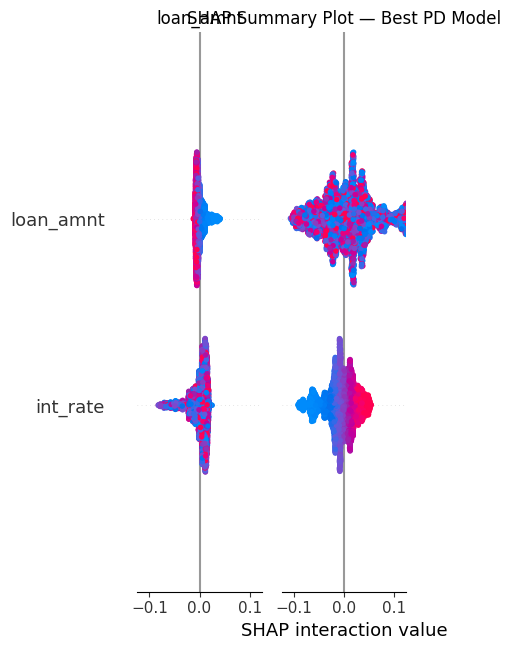

In [62]:
# ── 5.7  SHAP Feature Importance — Best PD Model ────────────────────────────
# Extract the raw XGB/tree estimator from the calibrated pipeline for SHAP
try:
    raw_pipe = calibrated_pd.estimator
    clf_step = raw_pipe.named_steps.get('clf')
    if clf_step is not None and hasattr(clf_step, 'feature_importances_'):
        # Transform features through scaler only (SMOTE not needed at inference)
        scaler_step = raw_pipe.named_steps.get('scaler', None)
        X_test_scaled = scaler_step.transform(X_test) if scaler_step else X_test.values
        explainer = shap.TreeExplainer(clf_step)
        shap_vals = explainer.shap_values(X_test_scaled)
        shap_vals_pos = shap_vals[1] if isinstance(shap_vals, list) else shap_vals
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_vals_pos, X_test_scaled,
                          feature_names=FEATURES, show=False)
        plt.title('SHAP Summary Plot — Best PD Model')
        plt.tight_layout()
        plt.savefig('pd_shap_summary.png', dpi=120)
        plt.show()
    else:
        # For linear models: use coefficients
        if hasattr(clf_step, 'coef_'):
            coef_series = pd.Series(clf_step.coef_[0], index=FEATURES).abs().sort_values(ascending=False)
            coef_series.plot(kind='bar', figsize=(10, 5), title='Logistic Regression — |Coefficients|')
            plt.tight_layout(); plt.savefig('pd_feature_importance.png', dpi=120); plt.show()
        print('SHAP TreeExplainer not applicable for this model type — skipped.')
except Exception as e:
    print(f'SHAP skipped: {e}')


## Step 6 — LGD Model (Loss Given Default)

> **Approach:** Structured regression model progression — Dummy → Ridge → Lasso → ElasticNet →
> Decision Tree → Random Forest → Extra Trees → GBM → XGBoost → LightGBM.
> All experiments are tracked with **MLflow**. Best model by Test MAE is saved.
>
> **Design principles:**
> - LGD is only modelled on **defaulted loans** (where `default == 1`)
> - Target `lgd` is clipped to [0, 1] after prediction
> - `sklearn.Pipeline` ensures scaler is fit only on training defaulted-loan subset
> - Best model is serialised as `lgd_model.pkl` for downstream EL computation


In [63]:
# ── 6.0  Prepare Defaulted-Loans Subsets ─────────────────────────────────────
df_defaulted_train = df_train[df_train['default'] == 1].copy()
df_defaulted_test  = df_test[df_test['default']  == 1].copy()

X_lgd_train = df_defaulted_train[FEATURES]
y_lgd_train = df_defaulted_train['lgd']
X_lgd_test  = df_defaulted_test[FEATURES]
y_lgd_test  = df_defaulted_test['lgd']

print(f'LGD train: {X_lgd_train.shape}  |  avg LGD = {y_lgd_train.mean():.4f}')
print(f'LGD test : {X_lgd_test.shape}   |  avg LGD = {y_lgd_test.mean():.4f}')


LGD train: (2723, 12)  |  avg LGD = 0.6883
LGD test : (1929, 12)   |  avg LGD = 0.7813


In [64]:
# ── 6.1  MLflow Setup & Helper ────────────────────────────────────────────────
MLFLOW_EXPERIMENT_LGD = 'credit_risk_LGD_model'
mlflow.set_experiment(MLFLOW_EXPERIMENT_LGD)
print(f'MLflow experiment set: {MLFLOW_EXPERIMENT_LGD}')

KF_LGD = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_lgd_model(name, pipeline, X_tr, y_tr, X_te, y_te):
    """Fit LGD regression pipeline, evaluate, log to MLflow."""
    with mlflow.start_run(run_name=name):
        cv_maes = -cross_val_score(pipeline, X_tr, y_tr,
                                   cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
        pipeline.fit(X_tr, y_tr)
        y_pred = np.clip(pipeline.predict(X_te), 0, 1)

        mae   = mean_absolute_error(y_te, y_pred)
        rmse  = np.sqrt(mean_squared_error(y_te, y_pred))
        r2    = r2_score(y_te, y_pred)
        train_mae = mean_absolute_error(y_tr, np.clip(pipeline.predict(X_tr), 0, 1))

        metrics = {
            'cv_mae_mean':  round(cv_maes.mean(), 4),
            'cv_mae_std':   round(cv_maes.std(),  4),
            'test_mae':     round(mae,  4),
            'test_rmse':    round(rmse, 4),
            'test_r2':      round(r2,   4),
            'train_mae':    round(train_mae, 4),
            'overfit_gap':  round(abs(mae - train_mae), 4),
        }
        mlflow.log_metrics(metrics)
        mlflow.log_param('model_name', name)
        mlflow.sklearn.log_model(pipeline, artifact_path='model')
        run_id = mlflow.active_run().info.run_id

    print(f'[{name:35s}]  CV MAE={metrics["cv_mae_mean"]:.4f} ± {metrics["cv_mae_std"]:.4f}  |  '
          f'Test MAE={metrics["test_mae"]:.4f}  RMSE={metrics["test_rmse"]:.4f}  R²={metrics["test_r2"]:.4f}')
    return {**metrics, 'model_name': name, 'pipeline': pipeline, 'run_id': run_id}

print('LGD helper defined. Starting model evaluation...')


MLflow experiment set: credit_risk_LGD_model
LGD helper defined. Starting model evaluation...


In [65]:
# ── 6.2  Baseline Regressors ─────────────────────────────────────────────────
print('=' * 75)
print('STAGE 1 — BASELINE REGRESSORS')
print('=' * 75)

lgd_results = []

# --- Dummy Regressor (mean baseline) ---
dummy_reg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reg',    DummyRegressor(strategy='mean'))
])
lgd_results.append(evaluate_lgd_model(
    'Dummy_Mean', dummy_reg_pipe, X_lgd_train, y_lgd_train, X_lgd_test, y_lgd_test))

# --- Ridge Regression ---
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reg',    Ridge(alpha=1.0))
])
lgd_results.append(evaluate_lgd_model(
    'Ridge', ridge_pipe, X_lgd_train, y_lgd_train, X_lgd_test, y_lgd_test))

# --- Lasso Regression ---
lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reg',    Lasso(alpha=0.01, max_iter=5000))
])
lgd_results.append(evaluate_lgd_model(
    'Lasso', lasso_pipe, X_lgd_train, y_lgd_train, X_lgd_test, y_lgd_test))

# --- ElasticNet ---
en_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reg',    ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=5000))
])
lgd_results.append(evaluate_lgd_model(
    'ElasticNet', en_pipe, X_lgd_train, y_lgd_train, X_lgd_test, y_lgd_test))

print('\nBaseline regressors complete.')


2026/02/23 14:34:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


STAGE 1 — BASELINE REGRESSORS


2026/02/23 14:34:22 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html
2026/02/23 14:34:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 14:34:25 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


[Dummy_Mean                         ]  CV MAE=0.1919 ± 0.0067  |  Test MAE=0.1750  RMSE=0.2014  R²=-0.2714


2026/02/23 14:34:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 14:34:29 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


[Ridge                              ]  CV MAE=0.1793 ± 0.0094  |  Test MAE=0.1684  RMSE=0.1982  R²=-0.2309


2026/02/23 14:34:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 14:34:32 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


[Lasso                              ]  CV MAE=0.1813 ± 0.0088  |  Test MAE=0.1691  RMSE=0.1963  R²=-0.2077
[ElasticNet                         ]  CV MAE=0.1802 ± 0.0092  |  Test MAE=0.1685  RMSE=0.1967  R²=-0.2125

Baseline regressors complete.


In [66]:
# ── 6.3  Tree-Based & Boosting Regressors ────────────────────────────────────
print('=' * 75)
print('STAGE 2 — TREE-BASED REGRESSORS')
print('=' * 75)

# --- Decision Tree ---
dt_reg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reg',    DecisionTreeRegressor(max_depth=5, random_state=42))
])
lgd_results.append(evaluate_lgd_model(
    'Decision_Tree', dt_reg_pipe, X_lgd_train, y_lgd_train, X_lgd_test, y_lgd_test))

# --- Random Forest ---
rf_reg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reg',    RandomForestRegressor(n_estimators=200, max_depth=6, random_state=42, n_jobs=-1))
])
lgd_results.append(evaluate_lgd_model(
    'Random_Forest', rf_reg_pipe, X_lgd_train, y_lgd_train, X_lgd_test, y_lgd_test))

# --- Extra Trees ---
et_reg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reg',    ExtraTreesRegressor(n_estimators=200, max_depth=6, random_state=42, n_jobs=-1))
])
lgd_results.append(evaluate_lgd_model(
    'Extra_Trees', et_reg_pipe, X_lgd_train, y_lgd_train, X_lgd_test, y_lgd_test))

print('\nTree-based regressors complete.')


2026/02/23 14:34:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


STAGE 2 — TREE-BASED REGRESSORS


2026/02/23 14:34:36 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


[Decision_Tree                      ]  CV MAE=0.1869 ± 0.0091  |  Test MAE=0.1745  RMSE=0.2086  R²=-0.3637


2026/02/23 14:34:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 14:34:45 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


[Random_Forest                      ]  CV MAE=0.1807 ± 0.0097  |  Test MAE=0.1679  RMSE=0.1984  R²=-0.2343


2026/02/23 14:34:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 14:34:53 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


[Extra_Trees                        ]  CV MAE=0.1801 ± 0.0099  |  Test MAE=0.1686  RMSE=0.1991  R²=-0.2423

Tree-based regressors complete.


In [67]:
# ── 6.4  Gradient Boosting Regressors ────────────────────────────────────────
print('=' * 75)
print('STAGE 3 — GRADIENT BOOSTING REGRESSORS')
print('=' * 75)

# --- Sklearn GBM ---
gbm_reg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reg',    GradientBoostingRegressor(n_estimators=200, max_depth=3,
                                         learning_rate=0.05, random_state=42))
])
lgd_results.append(evaluate_lgd_model(
    'GradientBoosting_sklearn', gbm_reg_pipe,
    X_lgd_train, y_lgd_train, X_lgd_test, y_lgd_test))

# --- XGBoost Regressor (tuned) ---
xgb_reg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reg',    xgb.XGBRegressor(random_state=42, n_jobs=-1))
])
xgb_reg_param_grid = {
    'reg__max_depth':     [3, 5],
    'reg__n_estimators':  [100, 200],
    'reg__learning_rate': [0.05, 0.1],
}
gs_lgd = GridSearchCV(xgb_reg_pipe, xgb_reg_param_grid,
                      scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, verbose=1)
gs_lgd.fit(X_lgd_train, y_lgd_train)
best_xgb_reg = gs_lgd.best_estimator_
print(f'XGBoost Regressor best params: {gs_lgd.best_params_}')

with mlflow.start_run(run_name='XGBoost_Reg_tuned'):
    y_pred_xgbr = np.clip(best_xgb_reg.predict(X_lgd_test), 0, 1)
    xgbr_metrics = {
        'cv_mae_mean':  round(-gs_lgd.best_score_, 4),
        'test_mae':     round(mean_absolute_error(y_lgd_test, y_pred_xgbr), 4),
        'test_rmse':    round(np.sqrt(mean_squared_error(y_lgd_test, y_pred_xgbr)), 4),
        'test_r2':      round(r2_score(y_lgd_test, y_pred_xgbr), 4),
        'train_mae':    round(mean_absolute_error(y_lgd_train,
                              np.clip(best_xgb_reg.predict(X_lgd_train), 0, 1)), 4),
        'cv_mae_std':   0.0,
    }
    xgbr_metrics['overfit_gap'] = round(abs(xgbr_metrics['test_mae'] - xgbr_metrics['train_mae']), 4)
    mlflow.log_params(gs_lgd.best_params_)
    mlflow.log_param('model_name', 'XGBoost_Reg_tuned')
    mlflow.log_metrics(xgbr_metrics)
    mlflow.sklearn.log_model(best_xgb_reg, artifact_path='model')
    xgbr_run_id = mlflow.active_run().info.run_id

lgd_results.append({**xgbr_metrics, 'model_name': 'XGBoost_Reg_tuned',
                    'pipeline': best_xgb_reg, 'run_id': xgbr_run_id})
print(f'[{"XGBoost_Reg_tuned":35s}]  CV MAE={xgbr_metrics["cv_mae_mean"]:.4f}  |  '
      f'Test MAE={xgbr_metrics["test_mae"]:.4f}  R²={xgbr_metrics["test_r2"]:.4f}')

# --- LightGBM Regressor ---
lgbm_reg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reg',    LGBMRegressor(n_estimators=200, max_depth=5,
                             learning_rate=0.05, random_state=42, verbose=-1))
])
lgd_results.append(evaluate_lgd_model(
    'LightGBM', lgbm_reg_pipe, X_lgd_train, y_lgd_train, X_lgd_test, y_lgd_test))

print('\nGradient boosting regressors complete.')


STAGE 3 — GRADIENT BOOSTING REGRESSORS


2026/02/23 14:35:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 14:35:02 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


[GradientBoosting_sklearn           ]  CV MAE=0.1807 ± 0.0105  |  Test MAE=0.1703  RMSE=0.2019  R²=-0.2774
Fitting 5 folds for each of 8 candidates, totalling 40 fits


2026/02/23 14:35:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 14:35:09 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


XGBoost Regressor best params: {'reg__learning_rate': 0.05, 'reg__max_depth': 3, 'reg__n_estimators': 100}
[XGBoost_Reg_tuned                  ]  CV MAE=0.1805  |  Test MAE=0.1683  R²=-0.2329


2026/02/23 14:35:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 14:35:14 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


[LightGBM                           ]  CV MAE=0.1817 ± 0.0097  |  Test MAE=0.1706  RMSE=0.2041  R²=-0.3053

Gradient boosting regressors complete.


In [68]:
# ── 6.5  LGD Model Leaderboard & Best Model Selection ────────────────────────
leaderboard_lgd = (
    pd.DataFrame(lgd_results)
    .drop(columns=['pipeline', 'run_id'])
    .sort_values('test_mae', ascending=True)
    .reset_index(drop=True)
)
print('\n── LGD Model Leaderboard (sorted by Test MAE ↑ = better) ──')
display(leaderboard_lgd)

# Select best model by test_mae (lowest)
best_lgd_result = min(lgd_results, key=lambda x: x['test_mae'])
best_lgd_model  = best_lgd_result['pipeline']
print(f'\n✅ Best LGD model: {best_lgd_result["model_name"]}  '
      f'(Test MAE = {best_lgd_result["test_mae"]:.4f}, '
      f'R² = {best_lgd_result["test_r2"]:.4f})')



── LGD Model Leaderboard (sorted by Test MAE ↑ = better) ──


,cv_mae_mean,cv_mae_std,test_mae,test_rmse,test_r2,train_mae,overfit_gap,model_name
0,0.1807,0.0097,0.1679,0.1984,-0.2343,0.1621,0.0058,Random_Forest
1,0.1805,0.0000,0.1683,0.1983,-0.2329,0.1686,0.0003,XGBoost_Reg_tuned
2,0.1793,0.0094,0.1684,0.1982,-0.2309,0.1774,0.0090,Ridge
3,0.1802,0.0092,0.1685,0.1967,-0.2125,0.1786,0.0101,ElasticNet
4,0.1801,0.0099,0.1686,0.1991,-0.2423,0.1683,0.0003,Extra_Trees
5,0.1813,0.0088,0.1691,0.1963,-0.2077,0.1798,0.0107,Lasso
6,0.1807,0.0105,0.1703,0.2019,-0.2774,0.1597,0.0106,GradientBoosting_sklearn
7,0.1817,0.0097,0.1706,0.2041,-0.3053,0.1441,0.0265,LightGBM
8,0.1869,0.0091,0.1745,0.2086,-0.3637,0.1710,0.0035,Decision_Tree
9,0.1919,0.0067,0.1750,0.2014,-0.2714,0.1918,0.0168,Dummy_Mean



✅ Best LGD model: Random_Forest  (Test MAE = 0.1679, R² = -0.2343)


── LGD Model Performance ──
Test  MAE  : 0.1679
Train MAE  : 0.1621  (gap = 0.0058)
Test  RMSE : 0.1984
Test  R²   : -0.2343


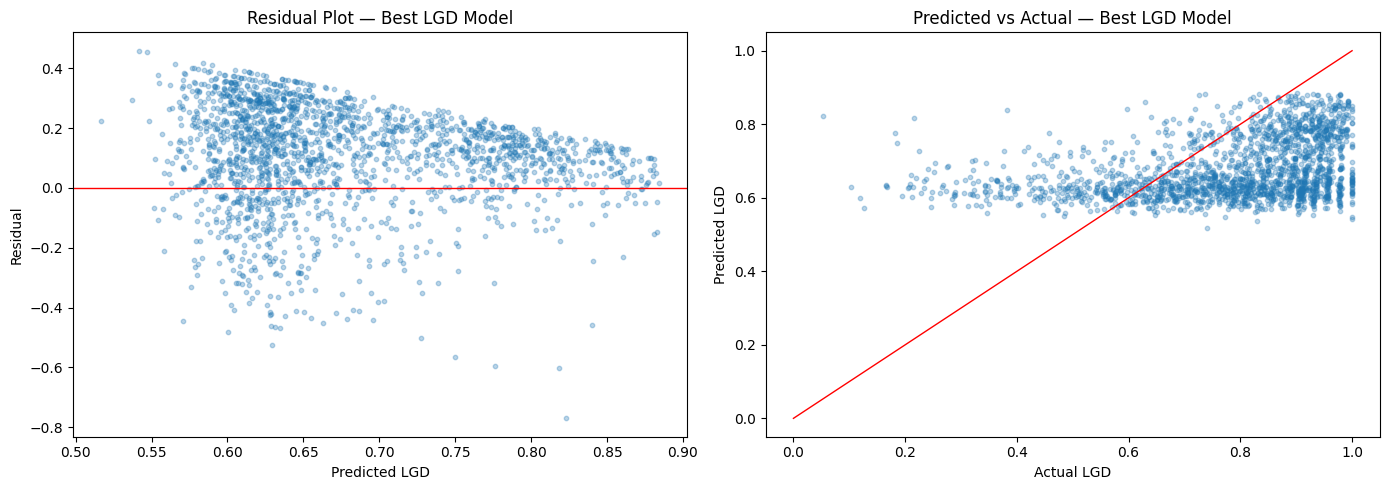

In [69]:
# ── 6.6  Full Evaluation of Best LGD Model ───────────────────────────────────
y_pred_lgd = np.clip(best_lgd_model.predict(X_lgd_test), 0, 1)
train_mae  = mean_absolute_error(y_lgd_train,
                                  np.clip(best_lgd_model.predict(X_lgd_train), 0, 1))

print('── LGD Model Performance ──')
print(f'Test  MAE  : {mean_absolute_error(y_lgd_test, y_pred_lgd):.4f}')
print(f'Train MAE  : {train_mae:.4f}  (gap = {abs(mean_absolute_error(y_lgd_test, y_pred_lgd) - train_mae):.4f})')
print(f'Test  RMSE : {np.sqrt(mean_squared_error(y_lgd_test, y_pred_lgd)):.4f}')
print(f'Test  R²   : {r2_score(y_lgd_test, y_pred_lgd):.4f}')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residual plot
residuals = y_lgd_test.values - y_pred_lgd
axes[0].scatter(y_pred_lgd, residuals, alpha=0.3, s=10)
axes[0].axhline(0, color='red', linewidth=1)
axes[0].set_xlabel('Predicted LGD'); axes[0].set_ylabel('Residual')
axes[0].set_title('Residual Plot — Best LGD Model')

# Predicted vs Actual
axes[1].scatter(y_lgd_test, y_pred_lgd, alpha=0.3, s=10)
axes[1].plot([0, 1], [0, 1], color='red', linewidth=1)
axes[1].set_xlabel('Actual LGD'); axes[1].set_ylabel('Predicted LGD')
axes[1].set_title('Predicted vs Actual — Best LGD Model')

plt.tight_layout()
plt.savefig('lgd_evaluation.png', dpi=120)
plt.show()


In [70]:
# ── 6.7  Adapter: Expose gs_lgd for Downstream Steps 7-9 ────────────────────
# Steps 7, 8, 9 use gs_lgd.predict(X_test) — we create a simple wrapper
# so that best_lgd_model is accessible via gs_lgd.predict() as expected.
class _BestModelWrapper:
    """Thin wrapper to expose .predict() compatible with gs_lgd.predict()."""
    def __init__(self, pipeline):
        self.best_estimator_ = pipeline
    def predict(self, X):
        return self.best_estimator_.predict(X)

gs_lgd = _BestModelWrapper(best_lgd_model)
print(f'gs_lgd wrapper set to best LGD model: {best_lgd_result["model_name"]}')
print('Steps 7, 8, 9 can now use gs_lgd.predict() as before.')

# ── Save best models as .pkl files (also done in Step 9, this is an interim save)
joblib.dump(calibrated_pd,  'pd_model.pkl')
joblib.dump(best_lgd_model, 'lgd_model.pkl')
print('Best models saved: pd_model.pkl, lgd_model.pkl')


gs_lgd wrapper set to best LGD model: Random_Forest
Steps 7, 8, 9 can now use gs_lgd.predict() as before.
Best models saved: pd_model.pkl, lgd_model.pkl


## Step 7 — Expected Loss (EL = PD × LGD × EAD)
> **What to observe:**
> - **EAD** (Exposure at Default) = `loan_amnt` (outstanding principal).
> - **EL per loan** is in dollar terms. Sort by EL descending to identify the riskiest loans.
> - **Total portfolio EL** as a % of total exposure should be in the range of **2–8%** for LendingClub data. Values far outside this range suggest model issues.
> - Compare `actual_loss` (true outcome) vs `expected_loss` (model) at the portfolio level to validate alignment.


In [72]:
df_test_el = df_test.copy()

# PD prediction (calibrated probabilities)
df_test_el['pd_pred'] = calibrated_pd.predict_proba(X_test)[:, 1]

# LGD prediction (only meaningful for defaults; for non-defaults use model estimate)
df_test_el['lgd_pred'] = np.clip(gs_lgd.predict(X_test), 0, 1)

# EAD = loan amount (outstanding exposure)
df_test_el['ead'] = df_test_el['loan_amnt']

# Expected Loss
df_test_el['expected_loss'] = (
    df_test_el['pd_pred'] *
    df_test_el['lgd_pred'] *
    df_test_el['ead']
)

# Actual Loss (realised)
df_test_el['actual_loss'] = df_test_el['default'] * df_test_el['lgd'] * df_test_el['ead']

total_exposure = df_test_el['ead'].sum()
total_el       = df_test_el['expected_loss'].sum()
total_actual   = df_test_el['actual_loss'].sum()

print(f'Total Portfolio Exposure : ${total_exposure:,.0f}')
print(f'Total Expected Loss (EL) : ${total_el:,.0f}  ({100*total_el/total_exposure:.2f}% of exposure)')
print(f'Total Actual Loss        : ${total_actual:,.0f}  ({100*total_actual/total_exposure:.2f}% of exposure)')
print(f'EL / Actual Ratio        : {total_el/total_actual:.2f}  (1.0 = perfect calibration)')

# Top 10 riskiest loans
df_test_el.sort_values('expected_loss', ascending=False)[
    ['loan_amnt','grade','int_rate','pd_pred','lgd_pred','expected_loss']
].head(10)


Total Portfolio Exposure : $91,252,575
Total Expected Loss (EL) : $23,235,693  (25.46% of exposure)
Total Actual Loss        : $27,364,946  (29.99% of exposure)
EL / Actual Ratio        : 0.85  (1.0 = perfect calibration)


,loan_amnt,grade,int_rate,pd_pred,lgd_pred,expected_loss
9154,35000.0000,7,28.3400,0.7294,0.8872,22649.0840
21115,35000.0000,7,28.8800,0.7294,0.8819,22515.5864
23337,35000.0000,7,30.7900,0.7294,0.8804,22475.1793
21824,35000.0000,7,28.1800,0.7294,0.8607,21974.2794
24046,35000.0000,7,30.7900,0.7294,0.8606,21969.8849
10243,34000.0000,7,27.4900,0.7294,0.8845,21935.4943
21542,34225.0000,7,29.6700,0.7294,0.8770,21894.0642
21475,35000.0000,7,29.6700,0.7294,0.8489,21672.8998
21905,35000.0000,7,30.9900,0.7294,0.8427,21514.7787
9951,35000.0000,7,28.9900,0.7294,0.8409,21468.0424


## Step 8 — Portfolio Monitoring (Quarterly EL Trend)
> **What to observe:**
> - Expected loss as a % of exposure should remain **stable or declining** post-2016 if the model is well-calibrated.
> - A diverging gap between predicted EL and actual loss over quarters signals **concept drift** — the model needs retraining.
> - The 2008–2009 period (if present in training data) should show a spike in actual losses. If the model misses this, it has not learned macroeconomic stress patterns.


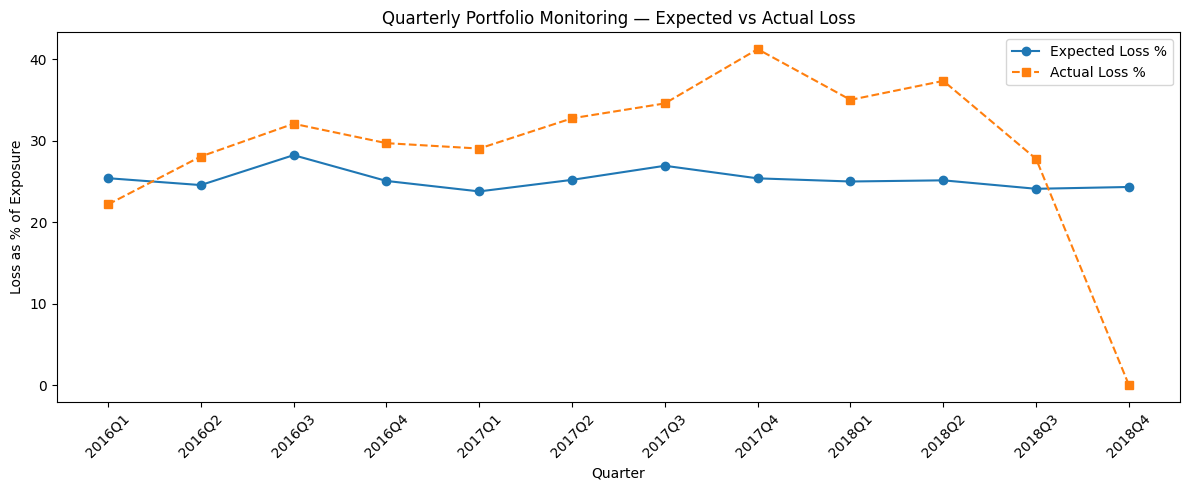

In [73]:
el_quarterly = df_test_el.groupby('quarter').agg(
    exposure        = ('ead', 'sum'),
    expected_loss   = ('expected_loss', 'sum'),
    actual_loss     = ('actual_loss', 'sum')
).reset_index()

el_quarterly['el_pct']     = el_quarterly['expected_loss'] / el_quarterly['exposure']
el_quarterly['actual_pct'] = el_quarterly['actual_loss']   / el_quarterly['exposure']

plt.figure(figsize=(12, 5))
plt.plot(el_quarterly['quarter'].astype(str),
         el_quarterly['el_pct'] * 100, label='Expected Loss %', marker='o')
plt.plot(el_quarterly['quarter'].astype(str),
         el_quarterly['actual_pct'] * 100, label='Actual Loss %', marker='s', linestyle='--')
plt.xlabel('Quarter'); plt.ylabel('Loss as % of Exposure')
plt.title('Quarterly Portfolio Monitoring — Expected vs Actual Loss')
plt.xticks(rotation=45)
plt.legend(); plt.tight_layout()
plt.savefig('portfolio_monitoring.png', dpi=120)
plt.show()


## Step 9 — Model Serialisation & Inference Example
> **What to observe:**
> - Both models are saved as `.pkl` files. Confirm the file sizes are reasonable (< 50 MB each).
> - The inference example demonstrates how to score a **new, unseen loan** using the saved models.
> - The output should be a dict with `pd`, `lgd`, and `el` keys — this is the deployable scoring API.


In [74]:
# Save models
joblib.dump(calibrated_pd, 'pd_model.pkl')
joblib.dump(gs_lgd.best_estimator_, 'lgd_model.pkl')
print('Models saved: pd_model.pkl, lgd_model.pkl')

# ── Inference on a new loan ──────────────────────────────────────────────────
pd_model_loaded  = joblib.load('pd_model.pkl')
lgd_model_loaded = joblib.load('lgd_model.pkl')

new_loan = pd.DataFrame([{
    'loan_amnt': 15000, 'int_rate': 14.5, 'annual_inc': 60000,
    'dti': 90.0, 'fico_score': 300, 'term': 36,
    'grade': 3, 'emp_length': 5,
    'delinq_2yrs': 0, 'inq_last_6mths': 1, 'revol_util': 45.0, 'open_acc': 8
}])

pd_score  = pd_model_loaded.predict_proba(new_loan)[0, 1]
lgd_score = float(np.clip(lgd_model_loaded.predict(new_loan)[0], 0, 1))
ead       = new_loan['loan_amnt'].values[0]
el        = pd_score * lgd_score * ead

print('=== New Loan Scoring ===')
print(f'PD  (Prob. of Default)  : {pd_score:.4f}')
print(f'LGD (Loss Given Default): {lgd_score:.4f}')
print(f'EAD (Exposure at Default): ${ead:,.0f}')
print(f'Expected Loss           : ${el:,.2f}')


Models saved: pd_model.pkl, lgd_model.pkl
=== New Loan Scoring ===
PD  (Prob. of Default)  : 0.3830
LGD (Loss Given Default): 0.6218
EAD (Exposure at Default): $15,000
Expected Loss           : $3,571.93
